In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data Read

In [3]:
raw_df = pd.read_csv('./B72_7MA_14MA_PS.csv')

In [4]:
raw_df.head(10)

,OrderDate,YYYYMM,YYYYWEEK,ORDERQTY,7MA,14MA,PS
0,2018-01-02,201801,20181,92,NaN,NaN,99.4
1,2018-01-03,201801,20181,130,NaN,NaN,99.4
2,2018-01-04,201801,20181,45,NaN,NaN,99.4
3,2018-01-05,201801,20181,54,NaN,NaN,99.4
4,2018-01-08,201801,20182,464,NaN,NaN,99.4
5,2018-01-09,201801,20182,60,NaN,NaN,99.4
6,2018-01-10,201801,20182,60,129.29,NaN,99.4
7,2018-01-11,201801,20182,50,123.29,NaN,99.4
8,2018-01-12,201801,20182,2,105.00,NaN,99.4
9,2018-01-15,201801,20183,85,110.71,NaN,99.4


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   OrderDate  1250 non-null   object 
 1   YYYYMM     1250 non-null   int64  
 2   YYYYWEEK   1250 non-null   int64  
 3   ORDERQTY   1250 non-null   int64  
 4   7MA        1244 non-null   float64
 5   14MA       1237 non-null   float64
 6   PS         1250 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 68.5+ KB


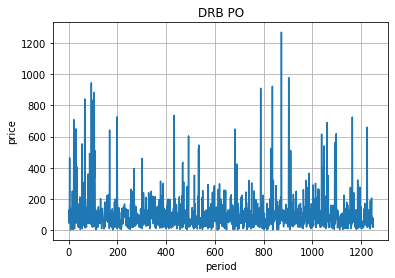

In [6]:
plt.title('DRB PO')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['ORDERQTY'], label='Adj Close')
plt.show()

### Data Preprocessing

In [7]:
raw_df.describe()

,YYYYMM,YYYYWEEK,ORDERQTY,7MA,14MA,PS
count,1250.000000,1250.00000,1250.000000,1244.000000,1237.000000,1250.000000
mean,201993.708000,171617.02640,106.640800,106.749502,106.770525,95.052640
std,135.890122,67870.93516,120.738314,50.587520,38.899247,10.454292
min,201801.000000,20181.00000,2.000000,32.000000,43.360000,62.200000
25%,201903.000000,201829.00000,42.000000,74.105000,80.210000,92.175000
50%,202005.000000,201947.00000,78.500000,92.860000,98.570000,96.600000
75%,202107.000000,202121.00000,125.750000,123.570000,120.860000,102.500000
max,202209.000000,202239.00000,1268.000000,397.000000,333.000000,109.200000


### 결측치 제거

In [8]:
raw_df.isnull().sum()

OrderDate     0
YYYYMM        0
YYYYWEEK      0
ORDERQTY      0
7MA           6
14MA         13
PS            0
dtype: int64

In [9]:
#컬럼에 0의 개수 확인
for col in raw_df.columns:
    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ':' + str(missing_rows))

OrderDate:0
YYYYMM:0
YYYYWEEK:0
ORDERQTY:0
7MA:0
14MA:0
PS:0


In [10]:
raw_df.loc[raw_df['14MA'].isna()]

,OrderDate,YYYYMM,YYYYWEEK,ORDERQTY,7MA,14MA,PS
0,2018-01-02,201801,20181,92,NaN,NaN,99.4
1,2018-01-03,201801,20181,130,NaN,NaN,99.4
2,2018-01-04,201801,20181,45,NaN,NaN,99.4
3,2018-01-05,201801,20181,54,NaN,NaN,99.4
4,2018-01-08,201801,20182,464,NaN,NaN,99.4
5,2018-01-09,201801,20182,60,NaN,NaN,99.4
6,2018-01-10,201801,20182,60,129.29,NaN,99.4
7,2018-01-11,201801,20182,50,123.29,NaN,99.4
8,2018-01-12,201801,20182,2,105.00,NaN,99.4
9,2018-01-15,201801,20183,85,110.71,NaN,99.4


In [11]:
#missing data 처리
raw_df = raw_df.dropna()
raw_df.isnull().sum()

OrderDate    0
YYYYMM       0
YYYYWEEK     0
ORDERQTY     0
7MA          0
14MA         0
PS           0
dtype: int64

### 정규화

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()
scale_col = ['ORDERQTY', '7MA', '14MA', 'PS']

In [22]:
scaled_df = scaler.fit_transform(raw_df[scale_col])
scaled_df

array([[0.0221169 , 0.08413699, 0.18174285, 0.79148936],
       [0.0300158 , 0.08024658, 0.16893385, 0.79148936],
       [0.19589258, 0.17728767, 0.1985223 , 0.79148936],
       ...,
       [0.01421801, 0.17769863, 0.1607858 , 0.76170213],
       [0.06161137, 0.16868493, 0.17066013, 0.76170213],
       [0.01421801, 0.12915068, 0.15829996, 0.76170213]])

In [23]:
scaled_df = pd.DataFrame(scaled_df, columns=scale_col)    #ndarray array -> DataFrame

In [38]:
scaled_df

,ORDERQTY,7MA,14MA,PS
0,0.022117,0.084137,0.181743,0.791489
1,0.030016,0.080247,0.168934,0.791489
2,0.195893,0.177288,0.198522,0.791489
3,0.085308,0.187096,0.214542,0.791489
4,0.036335,0.201178,0.213058,0.791489
...,...,...,...,...
1232,0.063981,0.217233,0.168174,0.761702
1233,0.033965,0.219178,0.162029,0.761702
1234,0.014218,0.177699,0.160786,0.761702
1235,0.061611,0.168685,0.170660,0.761702


### 수요예측을 위해 7MA, 14MA, ORDERQTY항목을 feature 선정
  - 정답은 ORDERQTY 선정
  - 시계열 데이터를 위한 windows size = 20

In [25]:
# 입력 파라미터 feature, label => numpy type
def make_sequence_dataset(feature, label, window_size):
    feature_list = []    #생성될 feature list
    label_list = []      #생설될 label list
    
    for i in range(len(feature)-windows_size):
        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])
    
    return np.array(feature_list), np.array(label_list)     

In [39]:
# feature_df, lablel_df 생성
feature_cols = ['7MA', '14MA', 'ORDERQTY']
label_cols = ['ORDERQTY']

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [40]:
# Dataframe -> numpy 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(1237, 3) (1237, 1)


In [41]:
feature_np[10]

array([0.48846575, 0.38644524, 0.41706161])

### 시계열 데이터 생성 (make_sequence_dataset)

In [65]:
windows_size = 40
X, Y = make_sequence_dataset(feature_np, label_np, windows_size)

In [66]:
print(X.shape, Y.shape)

(1197, 40, 3) (1197, 1)


In [67]:
print(X[1])

[[0.08024658 0.16893385 0.0300158 ]
 [0.17728767 0.1985223  0.19589258]
 [0.18709589 0.21454219 0.08530806]
 [0.20117808 0.21305759 0.03633491]
 [0.15616438 0.09988261 0.00236967]
 [0.11312329 0.09245961 0.0221169 ]
 [0.12093151 0.09000829 0.03791469]
 [0.38238356 0.25227869 0.55766193]
 [0.32408219 0.2766883  0.07819905]
 [0.48846575 0.38644524 0.41706161]
 [0.47358904 0.38592736 0.00631912]
 [0.51076712 0.38099019 0.07740916]
 [0.52249315 0.36127607 0.04581359]
 [0.52210959 0.36597155 0.0371248 ]
 [0.27632877 0.37581135 0.06161137]
 [0.26810959 0.33389725 0.06161137]
 [0.31468493 0.46682088 0.51105845]
 [0.32876712 0.46633752 0.03475513]
 [0.32876712 0.48974589 0.07740916]
 [0.39452055 0.53859964 0.17851501]
 [0.53386301 0.62612208 0.31832543]
 [0.5440274  0.47766193 0.0821485 ]
 [0.55186301 0.47742025 0.07740916]
 [0.36282192 0.38765364 0.12954186]
 [0.35654795 0.3925908  0.0221169 ]
 [0.34090411 0.38271648 0.04581359]
 [0.25947945 0.37287667 0.01421801]
 [0.16673973 0.40222345 0.13

### 학습데이터, 테스트데이터 생성

In [68]:
#train, test 분리
split = -100

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1097, 40, 3) (1097, 1)
(100, 40, 3) (100, 1)


### Model and Compile

In [69]:
#모델생성
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))
model.add(Dense(1, activation='linear'))

In [70]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               67584     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(loss='mse', optimizer='adam', metrics=['mae', 'acc'])

### 모델학습 (Early Stop)

In [72]:
from tensorflow.keras.callbacks import EarlyStopping

In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [74]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=20, callbacks=[early_stop])

Epoch 1/100
55/55 [==============================] - 2s 25ms/step - loss: 0.0094 - mae: 0.0577 - acc: 0.0027 - val_loss: 0.0077 - val_mae: 0.0592 - val_acc: 0.0000e+00
Epoch 2/100
55/55 [==============================] - 1s 17ms/step - loss: 0.0093 - mae: 0.0578 - acc: 0.0027 - val_loss: 0.0074 - val_mae: 0.0456 - val_acc: 0.0000e+00
Epoch 3/100
55/55 [==============================] - 1s 17ms/step - loss: 0.0090 - mae: 0.0564 - acc: 0.0027 - val_loss: 0.0076 - val_mae: 0.0579 - val_acc: 0.0000e+00
Epoch 4/100
55/55 [==============================] - 1s 18ms/step - loss: 0.0091 - mae: 0.0570 - acc: 0.0027 - val_loss: 0.0072 - val_mae: 0.0481 - val_acc: 0.0000e+00
Epoch 5/100
55/55 [==============================] - 1s 17ms/step - loss: 0.0090 - mae: 0.0559 - acc: 0.0027 - val_loss: 0.0076 - val_mae: 0.0580 - val_acc: 0.0000e+00
Epoch 6/100
55/55 [==============================] - 1s 17ms/step - loss: 0.0092 - mae: 0.0569 - acc: 0.0027 - val_loss: 0.0074 - val_mae: 0.0545 - val_acc: 0.0

### 예측을 통한 정답과 비교 (오차계산 MAPE, 평균절대값 백분율오차)

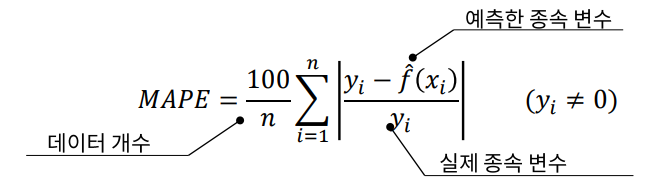

In [75]:
pred = model.predict(x_test)

In [76]:
pred.shape

(100, 1)

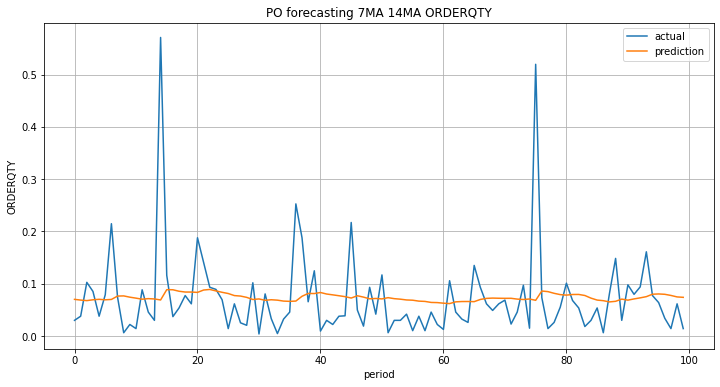

In [78]:
plt.figure(figsize=(12,6))
plt.title('PO forecasting 7MA 14MA ORDERQTY')
plt.ylabel('ORDERQTY')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()


In [54]:
# MAPE

print(np.sum(abs(y_test-pred)/y_test)/len(x_test))

1.9160375468662334
